# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

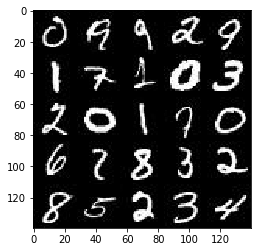

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

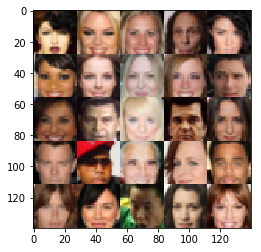

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')
  
    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):   
        
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x3, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
       
        out = tf.tanh(logits) 
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batches in get_batches(batch_size):
                steps += 1
                
                # Because of tanh activation in generator function
                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                # Seen in thread from forum for this project
                batches *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                # added learning_rate in dict
                _ = sess.run(d_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})
                # generator runs twice to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batches, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batches})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3679... Generator Loss: 0.0579
Epoch 1/2... Discriminator Loss: 1.7344... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 0.6368... Generator Loss: 1.4913
Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 2.6511
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 2.3064
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 2.4174
Epoch 1/2... Discriminator Loss: 0.4143... Generator Loss: 2.7210


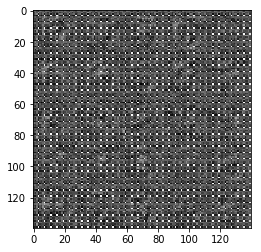

Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 2.7944
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 2.5068
Epoch 1/2... Discriminator Loss: 0.4127... Generator Loss: 2.6689
Epoch 1/2... Discriminator Loss: 2.6651... Generator Loss: 0.1924
Epoch 1/2... Discriminator Loss: 2.4777... Generator Loss: 0.2375
Epoch 1/2... Discriminator Loss: 2.0176... Generator Loss: 0.5193
Epoch 1/2... Discriminator Loss: 1.7876... Generator Loss: 0.4828
Epoch 1/2... Discriminator Loss: 1.9061... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.9812... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.8529... Generator Loss: 0.4184


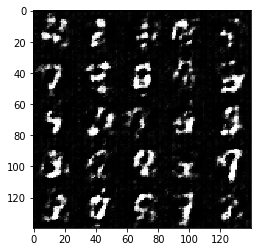

Epoch 1/2... Discriminator Loss: 1.5704... Generator Loss: 0.4909
Epoch 1/2... Discriminator Loss: 1.7464... Generator Loss: 0.4070
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.4897
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.4363
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.5280... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 1.0379


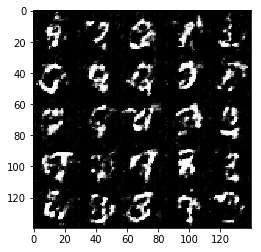

Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 1.9966... Generator Loss: 0.2417
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.5553
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.6207
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 0.3440
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 2.0734... Generator Loss: 0.2114
Epoch 1/2... Discriminator Loss: 1.7006... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.4728


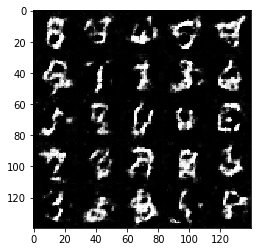

Epoch 1/2... Discriminator Loss: 1.5881... Generator Loss: 0.5567
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.7788... Generator Loss: 0.3175
Epoch 1/2... Discriminator Loss: 1.7178... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.6120... Generator Loss: 0.4612
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 1.7341... Generator Loss: 0.3852


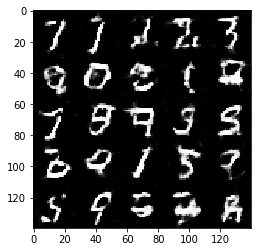

Epoch 1/2... Discriminator Loss: 1.5659... Generator Loss: 0.3921
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.8424... Generator Loss: 0.3155
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.5965
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 1.2792
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.3949
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 1.4693... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.7481


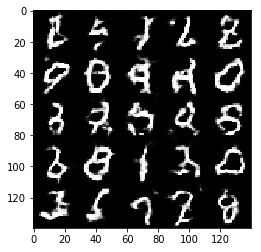

Epoch 1/2... Discriminator Loss: 1.8080... Generator Loss: 0.3002
Epoch 1/2... Discriminator Loss: 1.6495... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.6713
Epoch 1/2... Discriminator Loss: 1.8543... Generator Loss: 0.2985
Epoch 1/2... Discriminator Loss: 1.6710... Generator Loss: 0.4087
Epoch 1/2... Discriminator Loss: 1.6445... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8878


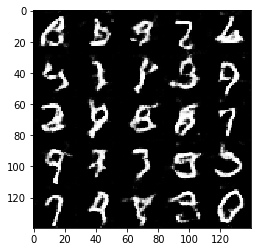

Epoch 1/2... Discriminator Loss: 1.5804... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.9188
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.7567... Generator Loss: 0.3023
Epoch 1/2... Discriminator Loss: 1.6319... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.8809


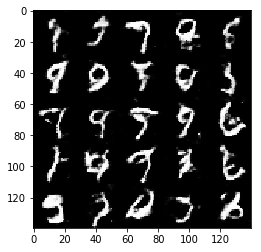

Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.7591... Generator Loss: 0.3271
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 2.3744... Generator Loss: 2.0517
Epoch 1/2... Discriminator Loss: 1.5313... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.4954... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.8790... Generator Loss: 0.2637
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 1.9998... Generator Loss: 0.2280
Epoch 1/2... Discriminator Loss: 1.8921... Generator Loss: 0.2671


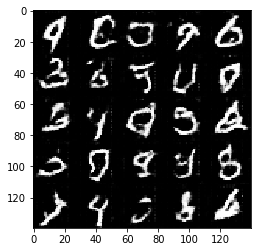

Epoch 1/2... Discriminator Loss: 1.8234... Generator Loss: 0.3039
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.6518
Epoch 1/2... Discriminator Loss: 1.6336... Generator Loss: 0.4221
Epoch 1/2... Discriminator Loss: 1.8862... Generator Loss: 0.2769
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.4919
Epoch 1/2... Discriminator Loss: 1.5882... Generator Loss: 0.4657


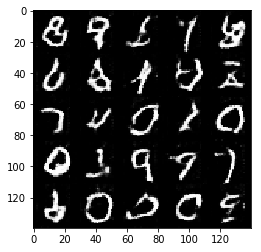

Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.4419
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.7316... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 1.8368... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 1.6908... Generator Loss: 0.3805
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.7761... Generator Loss: 1.8317


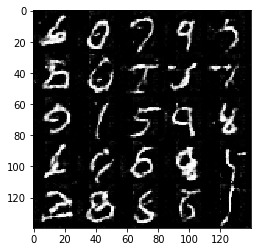

Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.8663... Generator Loss: 0.2627
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.6642
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.4706
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 1.6336... Generator Loss: 0.3489


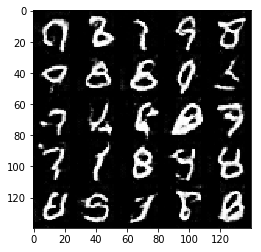

Epoch 1/2... Discriminator Loss: 2.0121... Generator Loss: 0.2301
Epoch 1/2... Discriminator Loss: 1.8860... Generator Loss: 0.2948
Epoch 1/2... Discriminator Loss: 1.5771... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 1.6997... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.7688... Generator Loss: 0.3346
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 0.8110


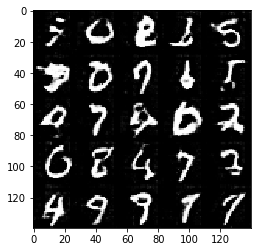

Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.4171
Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.6756... Generator Loss: 0.4095
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.6410... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.7073... Generator Loss: 0.3429


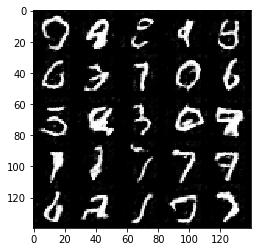

Epoch 1/2... Discriminator Loss: 1.7112... Generator Loss: 0.3175
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 0.8856
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.4280
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.9304... Generator Loss: 0.2808
Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.7791... Generator Loss: 0.3245
Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.5691


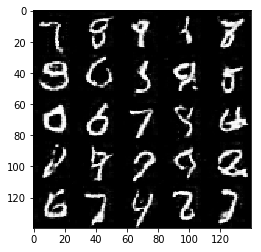

Epoch 1/2... Discriminator Loss: 1.6275... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.4639
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.4603


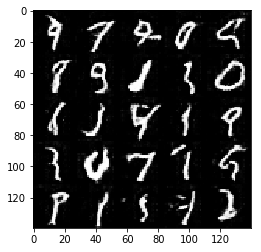

Epoch 1/2... Discriminator Loss: 1.6964... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.6570... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.7480... Generator Loss: 0.3360
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.4072
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 2.1990... Generator Loss: 0.1887


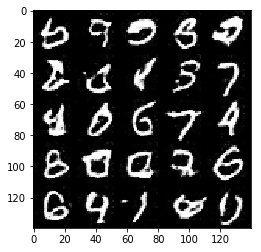

Epoch 1/2... Discriminator Loss: 1.7193... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.4168
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.8364... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.4882
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.8417
Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.5666... Generator Loss: 0.4371
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 1.7527... Generator Loss: 0.3216


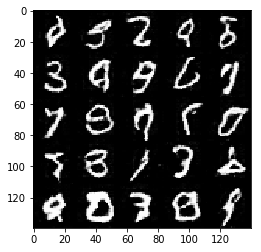

Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.5858... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.8944... Generator Loss: 0.2759
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.9205


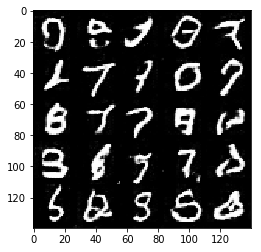

Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 1.4444
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.5901
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.6294
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.6369... Generator Loss: 0.4788
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 1.0457


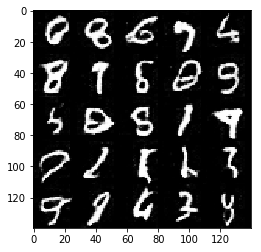

Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.6966... Generator Loss: 0.4485
Epoch 2/2... Discriminator Loss: 1.5765... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.5953... Generator Loss: 0.4169
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.4682
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.5328... Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 1.4411... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.5739


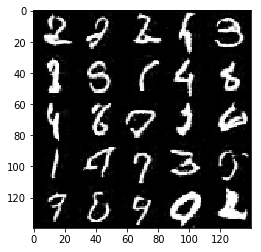

Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.5746
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.6873
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.8462... Generator Loss: 0.2824
Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.6337


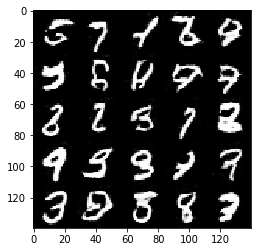

Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 0.4604
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 1.3213
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.6158... Generator Loss: 0.3873
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.6904... Generator Loss: 0.3260
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6068


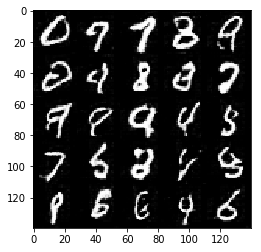

Epoch 2/2... Discriminator Loss: 1.4577... Generator Loss: 0.4639
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.5354
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.6023
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 1.8911... Generator Loss: 0.2628
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.5472
Epoch 2/2... Discriminator Loss: 1.4393... Generator Loss: 0.5578
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.7586


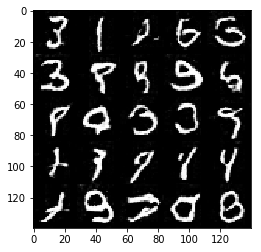

Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.6344... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 1.7686... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.5152
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 1.7831... Generator Loss: 0.3141
Epoch 2/2... Discriminator Loss: 1.5759... Generator Loss: 0.3972


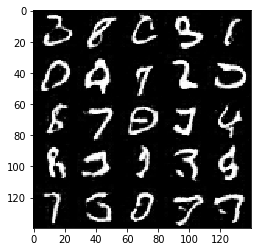

Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.4877
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 0.6054
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.4802... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.6464


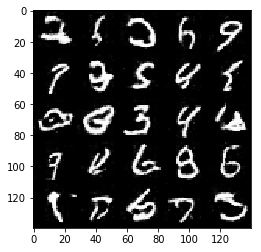

Epoch 2/2... Discriminator Loss: 1.5432... Generator Loss: 0.5189
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.4415
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 1.0677
Epoch 2/2... Discriminator Loss: 1.3323... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.5082... Generator Loss: 0.4278
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.5893


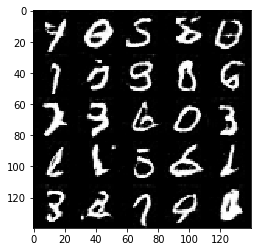

Epoch 2/2... Discriminator Loss: 1.4829... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.5454... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 0.7469
Epoch 2/2... Discriminator Loss: 1.5627... Generator Loss: 0.4156
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.6146
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.6365... Generator Loss: 0.3829
Epoch 2/2... Discriminator Loss: 1.6587... Generator Loss: 0.4730
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.5553
Epoch 2/2... Discriminator Loss: 1.5001... Generator Loss: 0.4837


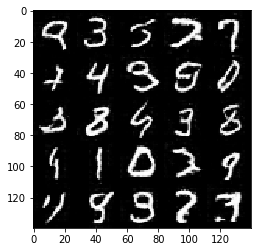

Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 1.7496... Generator Loss: 0.3134
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.4990
Epoch 2/2... Discriminator Loss: 1.4837... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.5432... Generator Loss: 0.5219
Epoch 2/2... Discriminator Loss: 2.7127... Generator Loss: 0.1328
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.6608


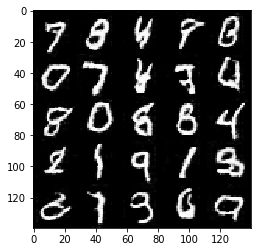

Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.5617
Epoch 2/2... Discriminator Loss: 1.7162... Generator Loss: 0.3424
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.5232
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.7069
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 1.5946... Generator Loss: 0.4673
Epoch 2/2... Discriminator Loss: 1.6845... Generator Loss: 0.3594


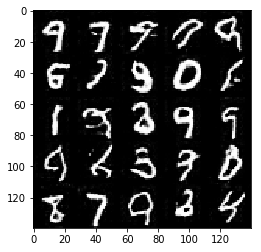

Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.5534
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 1.5461... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.4303
Epoch 2/2... Discriminator Loss: 2.0451... Generator Loss: 0.2410
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.5661... Generator Loss: 0.4742


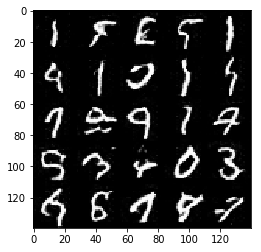

Epoch 2/2... Discriminator Loss: 1.7453... Generator Loss: 0.3429
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 1.4703... Generator Loss: 0.4538
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.6362... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.8195


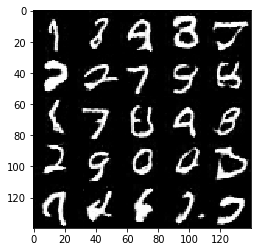

Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.4648... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.6379
Epoch 2/2... Discriminator Loss: 1.5164... Generator Loss: 0.4586
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 0.4403
Epoch 2/2... Discriminator Loss: 1.5194... Generator Loss: 0.4227


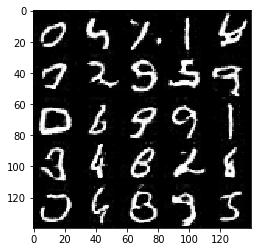

Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.6273... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 1.4240... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.5821... Generator Loss: 0.4240
Epoch 2/2... Discriminator Loss: 1.5008... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 0.4777
Epoch 2/2... Discriminator Loss: 1.7896... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 1.8911... Generator Loss: 0.2816


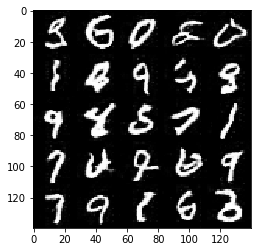

Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.5631
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.4633
Epoch 2/2... Discriminator Loss: 1.6650... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.6743
Epoch 2/2... Discriminator Loss: 1.5995... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.5226... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.4871


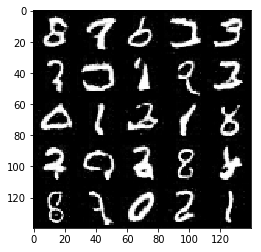

Epoch 2/2... Discriminator Loss: 1.5525... Generator Loss: 0.5566
Epoch 2/2... Discriminator Loss: 1.5587... Generator Loss: 0.4417
Epoch 2/2... Discriminator Loss: 2.2778... Generator Loss: 1.5643
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.4728
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.5290
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.5396
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.5361


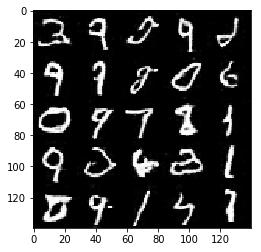

Epoch 2/2... Discriminator Loss: 1.6592... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.8898... Generator Loss: 0.2910
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.6761... Generator Loss: 0.3669
Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.4630... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.8815... Generator Loss: 0.2869


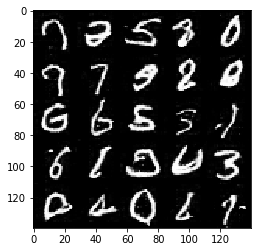

Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.5535
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.8930... Generator Loss: 0.2899
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.9674
Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.5658


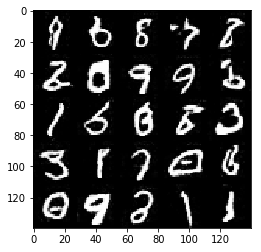

Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 1.7847... Generator Loss: 0.3283
Epoch 2/2... Discriminator Loss: 1.5952... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 1.9190... Generator Loss: 0.2801
Epoch 2/2... Discriminator Loss: 1.8015... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.5058


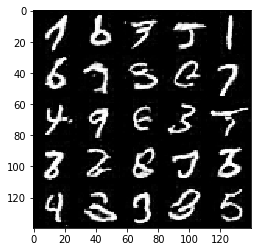

Epoch 2/2... Discriminator Loss: 1.6667... Generator Loss: 0.3876
Epoch 2/2... Discriminator Loss: 1.5906... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 1.6672... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.4859
Epoch 2/2... Discriminator Loss: 1.5506... Generator Loss: 0.3930
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 0.7397


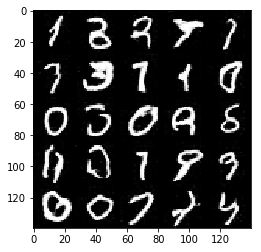

In [30]:
batch_size = 30
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.2728... Generator Loss: 0.0126
Epoch 1/1... Discriminator Loss: 3.9477... Generator Loss: 0.0344
Epoch 1/1... Discriminator Loss: 3.5359... Generator Loss: 0.0583
Epoch 1/1... Discriminator Loss: 3.4073... Generator Loss: 0.0548
Epoch 1/1... Discriminator Loss: 3.3140... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 3.0583... Generator Loss: 0.1295
Epoch 1/1... Discriminator Loss: 2.6034... Generator Loss: 0.1753
Epoch 1/1... Discriminator Loss: 2.4605... Generator Loss: 0.3055
Epoch 1/1... Discriminator Loss: 2.3403... Generator Loss: 0.2186
Epoch 1/1... Discriminator Loss: 2.3932... Generator Loss: 0.2662


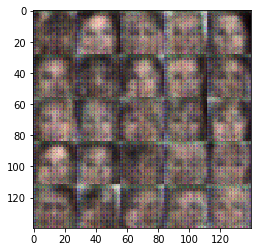

Epoch 1/1... Discriminator Loss: 2.3018... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 1.9980... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 2.1485... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 1.9404... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 1.9366... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.8827... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 1.9467... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.8331... Generator Loss: 0.4301


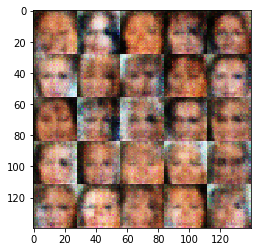

Epoch 1/1... Discriminator Loss: 1.6485... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.8379... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.6001


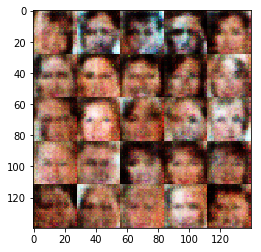

Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.6548


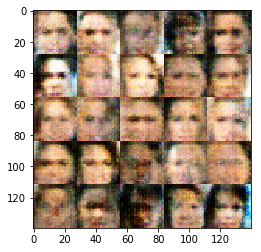

Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.6962... Generator Loss: 0.5491


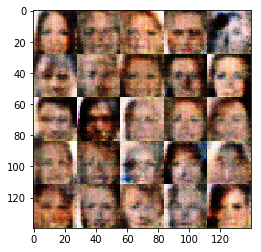

Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.6344


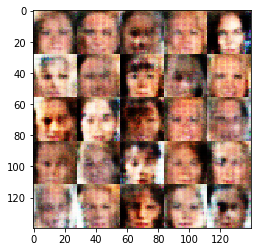

Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6954


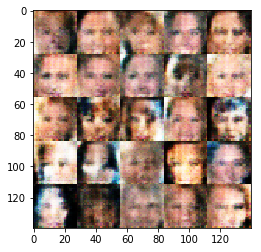

Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6748


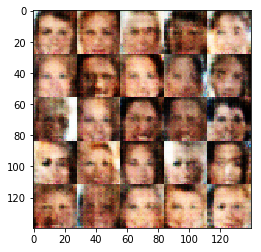

Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7080


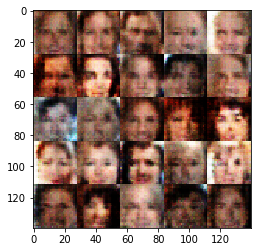

Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.8048


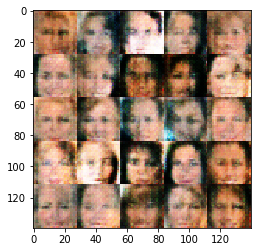

Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6598


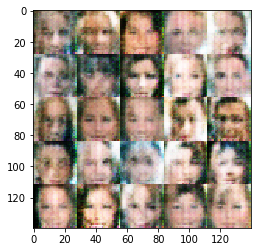

Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7453


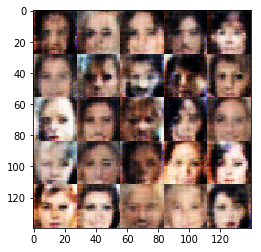

Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7085


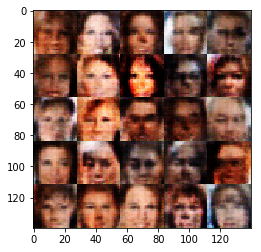

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.6605


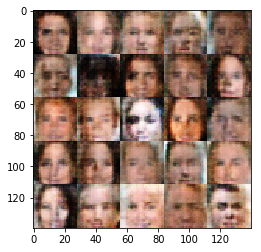

Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6963


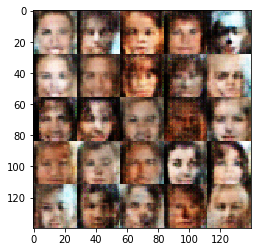

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7004


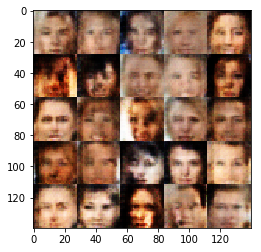

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7045


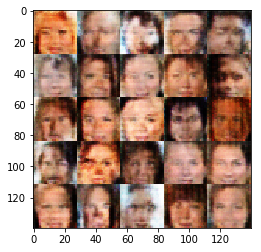

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6878


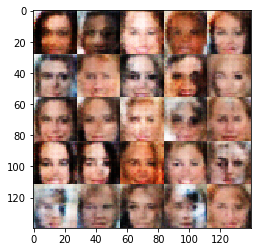

Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6722


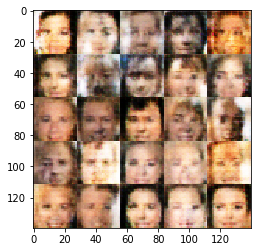

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7462


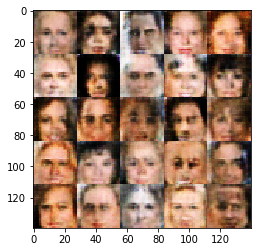

Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8271


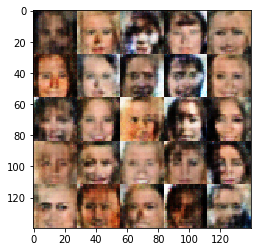

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7220


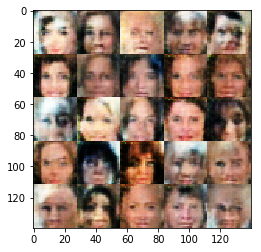

Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.7263


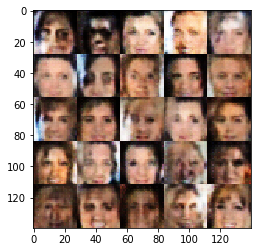

Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7217


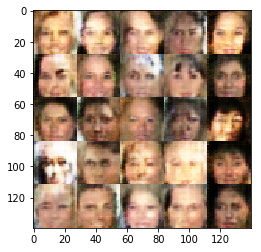

Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6812


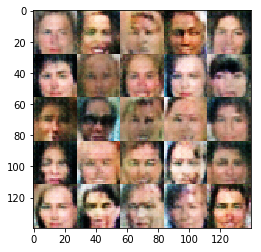

Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7144


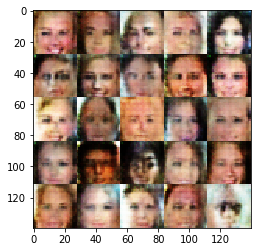

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7305


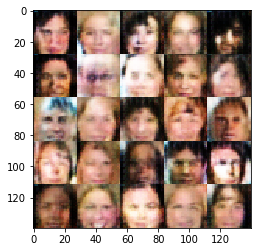

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6516


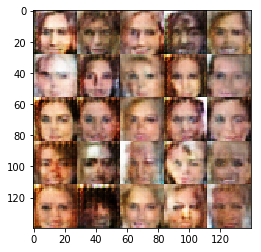

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7211


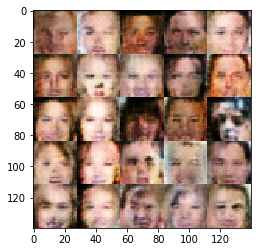

Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7174


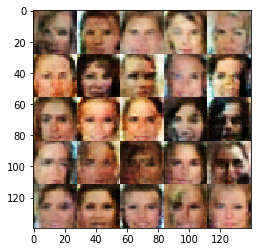

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.8050


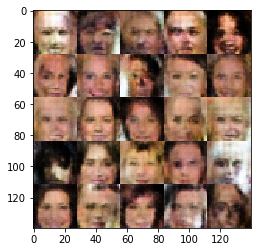

Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6862


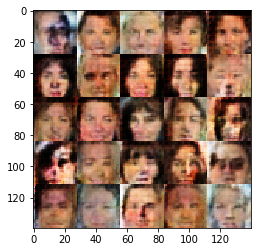

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6985


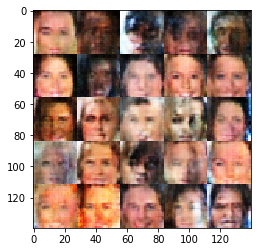

Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.6908


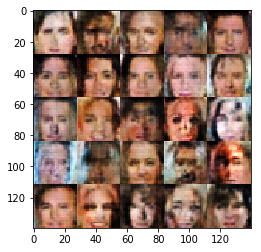

Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.6731


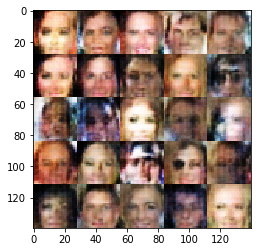

Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7211


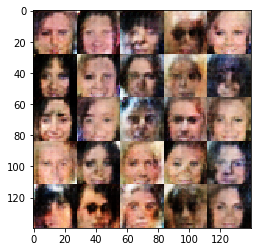

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7656


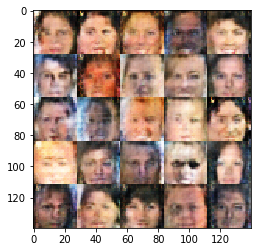

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7801


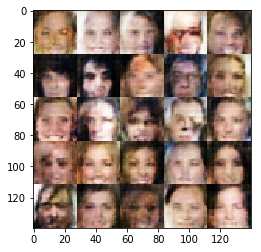

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.6688


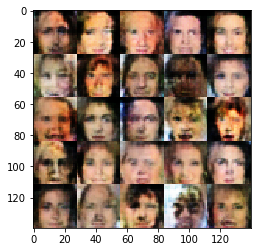

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6843


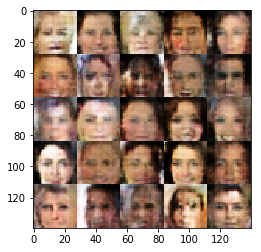

Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7559


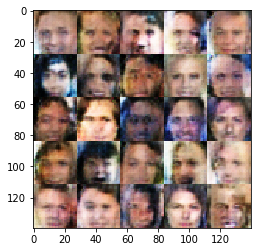

Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7003


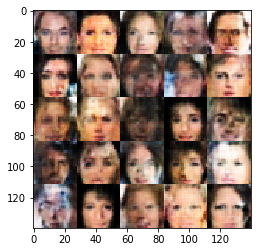

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7434


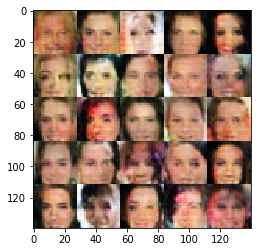

Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8819


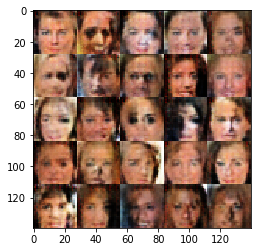

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7274


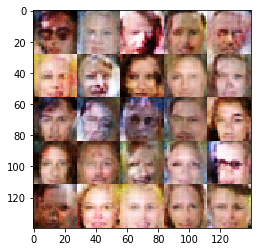

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7163


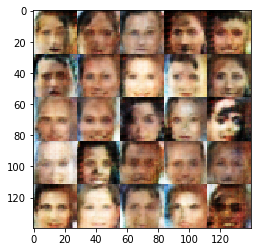

Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6787


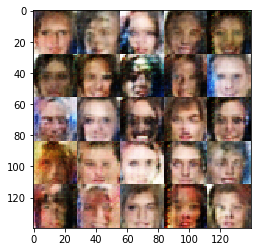

Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7136


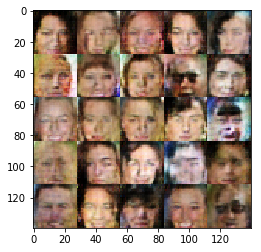

Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7659


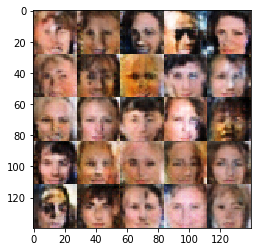

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8103


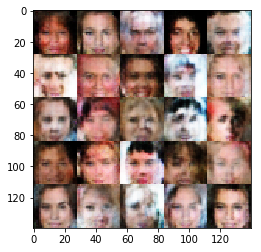

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7605


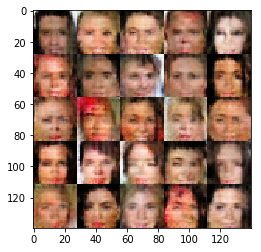

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7413


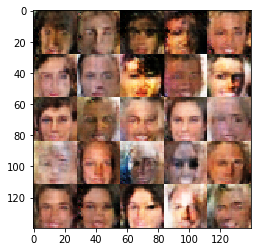

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7961


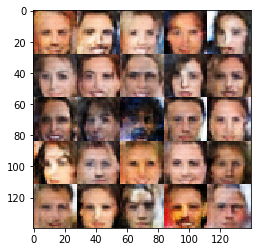

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7520


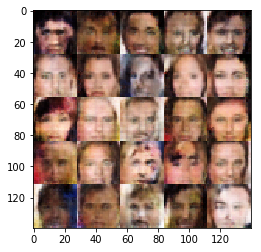

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7125


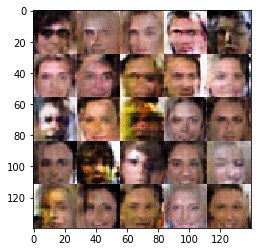

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7004


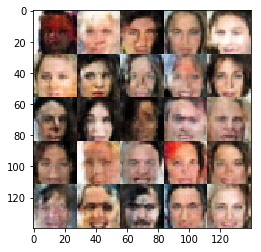

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7621


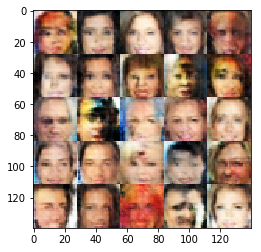

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6938


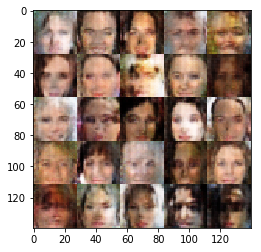

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7946


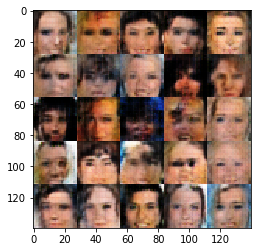

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8147


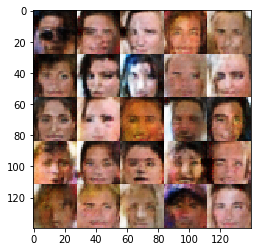

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7823


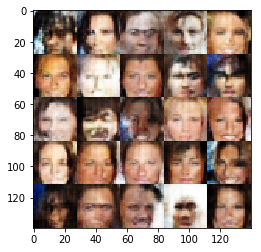

Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7571


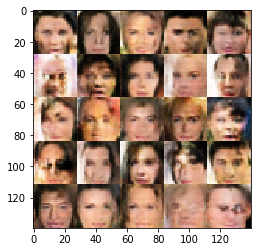

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8393


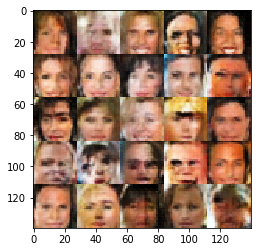

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7753


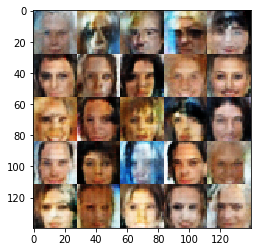

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7069


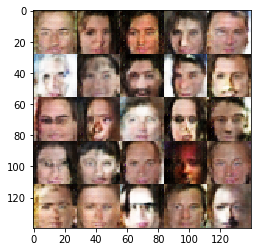

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6878


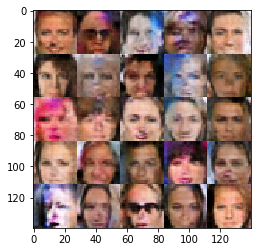

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6555


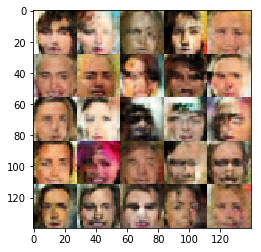

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7536


In [31]:
batch_size = 30
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.